# Install all libraries needed


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

In [ ]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub


In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#Data preparation


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
dataframe = pd.read_excel('Final_700_CRP.xlsx')

In [ ]:
data=dataframe.copy()
data.head()

,Category,Text
0,0,"BOSTON--(BUSINESS WIRE)--airSlate, a global le..."
1,0,NEW YORK & SAN FRANCISCO & LONDON--(BUSINESS W...
2,0,SAN DIEGO--(BUSINESS WIRE)--FutureProof Techno...
3,0,"DUBAI, United Arab Emirates & KARACHI, Pakista..."
4,0,"OS ANGELES & TAMPA, Fla.--(BUSINESS WIRE)--Lea..."


In [ ]:
len(data.index)

700

In [ ]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Text'],df['Category'], stratify=df['Category'])

#BERT model

In [ ]:
#choose preprocessing and encoder 
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
#Build the model 

# Bert layers
bert_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(bert_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[bert_input], outputs = [l])

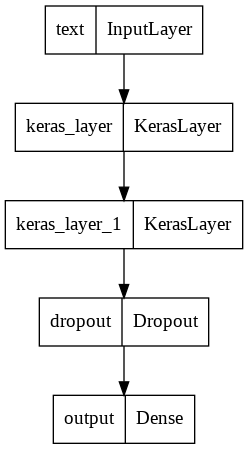

In [ ]:
#see shape of the model
tf.keras.utils.plot_model(model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training the model


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size = 24)

Epoch 1/10
18/22 [=======================>......] - ETA: 47s - loss: 0.7227 - accuracy: 0.5208

KeyboardInterrupt: ignored

# Testing the model

In [ ]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 78s 13s/step - loss: 0.5616 - accuracy: 0.7543


[0.5615730285644531, 0.7542856931686401]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

6/6 [==============================] - 77s 12s/step


In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
model.save('my_model.h5')

# Evaluation

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1])

In [ ]:
#draw the confusion matrix between predicted and actual
confusion_matrix(y_predicted, y_test) 

array([[62, 17],
       [26, 70]])

In [ ]:
#have a look at other metrics
print(metrics.classification_report(y_test, y_predicted, digits=3))

              precision    recall  f1-score   support

           0      0.500     0.011     0.022        88
           1      0.497     0.989     0.662        87

    accuracy                          0.497       175
   macro avg      0.499     0.500     0.342       175
weighted avg      0.499     0.497     0.340       175



# Type I and type II errors


In [ ]:
y_predicted
j=175

In [ ]:
df_test=pd.DataFrame()

In [ ]:
df_test['X']=X_test
df_test['Y']=y_test

In [ ]:
df_test.index = range(len(df_test))

In [ ]:
for i in range(j):
  if y_predicted[i]<0.50:
    df_test=df_test.drop(i)
df_test.index = range(len(df_test))

In [ ]:
type1=df_test['Y']==0

In [ ]:
df_test[type1]
#check if similarities in the texts

,X,Y
2,"Eightfold AI offers a, AI-driven talent intell...",0
9,LOS ANGELES--(BUSINESS WIRE)--Just three month...,0
16,ermany’s stable of unicorns can count one more...,0
21,"Zymochem – Another Berkeley, Calif.-startup, Z...",0
23,"Metaphysic, the company behind the Tom Cruise ...",0
27,After sustaining a major blow from a pandemic-...,0
32,"Belgian foodtech startup Deliverect, which pro...",0
41,In order to support a buildout of renewable en...,0
45,Hyro provides conversational AI offerings with...,0
46,"Despite the COVID-19 pandemic, Nexa3D has achi...",0
